# Analysis of travel behavior

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from dotenv import load_dotenv
import sql_functions as sf

%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#plot Style
sns.set_style("whitegrid")

### Import dataframes from postgres

In [41]:
# enter the schema name for your course
schema = 'capstone_travel_index'

df_env = sf.get_dataframe(f'SELECT * FROM {schema}.df_env_scr')
df_gov = sf.get_dataframe(f'SELECT * FROM {schema}.df_gov_scr')
df_soc = sf.get_dataframe(f'SELECT * FROM {schema}.df_soc_scr')
df_arr = sf.get_dataframe(f'SELECT iso3, year, total FROM {schema}.arrival_regions')
df_arr_eu = sf.get_dataframe(f'SELECT iso3, year, europe FROM {schema}.arrival_regions')
df_price = sf.get_dataframe(f'SELECT iso3, item_id, price_avg_eur total FROM {schema}.country_avg_price')


In [42]:
print(df_env.info())
print(df_gov.info())
print(df_soc.info())
print(df_price.info())
print(df_arr.info())
print(df_arr_eu.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1930 entries, 0 to 1929
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   iso3       1930 non-null   object        
 1   year       1930 non-null   datetime64[ns]
 2   env_score  1930 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 45.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1930 entries, 0 to 1929
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   iso3       1930 non-null   object        
 1   year       1930 non-null   datetime64[ns]
 2   gov_score  1930 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 45.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1930 entries, 0 to 1929
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------

In [25]:
df_arr.dropna(inplace=True)

In [43]:
df_arr_eu.dropna(inplace=True)

In [45]:
print(df_env.head())
print(df_gov.head())
print(df_gov.head())
print(df_arr.head())
print(df_arr_eu.head())

  iso3       year  env_score
0  AFG 2012-01-01   0.492424
1  AFG 2013-01-01   0.606061
2  AFG 2014-01-01   0.813309
3  AFG 2015-01-01   1.054545
4  AFG 2016-01-01   1.152482
  iso3       year  gov_score
0  AFG 2012-01-01   1.224490
1  AFG 2013-01-01   1.134969
2  AFG 2014-01-01   1.277719
3  AFG 2015-01-01   1.078749
4  AFG 2016-01-01   1.041890
  iso3       year  gov_score
0  AFG 2012-01-01   1.224490
1  AFG 2013-01-01   1.134969
2  AFG 2014-01-01   1.277719
3  AFG 2015-01-01   1.078749
4  AFG 2016-01-01   1.041890
  iso3       year  total
0  AFG 2012-01-01    NaN
1  AFG 2013-01-01    NaN
2  AFG 2014-01-01    NaN
3  AFG 2015-01-01    NaN
4  AFG 2016-01-01    NaN
   iso3       year  europe
10  ALB 2012-01-01  3214.0
11  ALB 2013-01-01  2964.0
12  ALB 2014-01-01  3424.0
13  ALB 2015-01-01  3759.0
14  ALB 2016-01-01  4485.0


### Create Datafram with all the scores and travel data

In [46]:
df_analysis = pd.merge(df_env, df_gov, on=['iso3', 'year'])
df_analysis = pd.merge(df_analysis, df_soc, on=['iso3', 'year'])
df_analysis = pd.merge(df_analysis, df_arr, on=['iso3', 'year'])
df_analysis = pd.merge(df_analysis, df_arr_eu, on=['iso3', 'year'])

In [47]:
df_analysis.head()

,iso3,year,env_score,gov_score,soc_score,total,europe
0,AGO,2012-01-01,3.049242,2.581633,2.311978,528.0,177.0
1,AGO,2013-01-01,3.484848,2.597137,2.545932,650.0,231.0
2,AGO,2014-01-01,3.548983,2.734952,2.220762,595.0,326.0
3,AGO,2015-01-01,3.854545,2.524272,2.706965,592.0,198.0
4,AGO,2016-01-01,4.007092,2.642320,2.571059,397.0,213.0


In [48]:
# Select specific years
sel_years = ['2012-01-01', 
             '2013-01-01', 
             '2014-01-01', 
             '2015-01-01', 
             '2016-01-01', 
             '2017-01-01', 
             '2018-01-01', 
             '2019-01-01']

# Filter the DataFrame based on the selected years
df_analysis_bc = df_analysis[df_analysis['year'].isin(sel_years)]

In [49]:
df_analysis_bc.head()

,iso3,year,env_score,gov_score,soc_score,total,europe
0,AGO,2012-01-01,3.049242,2.581633,2.311978,528.0,177.0
1,AGO,2013-01-01,3.484848,2.597137,2.545932,650.0,231.0
2,AGO,2014-01-01,3.548983,2.734952,2.220762,595.0,326.0
3,AGO,2015-01-01,3.854545,2.524272,2.706965,592.0,198.0
4,AGO,2016-01-01,4.007092,2.642320,2.571059,397.0,213.0


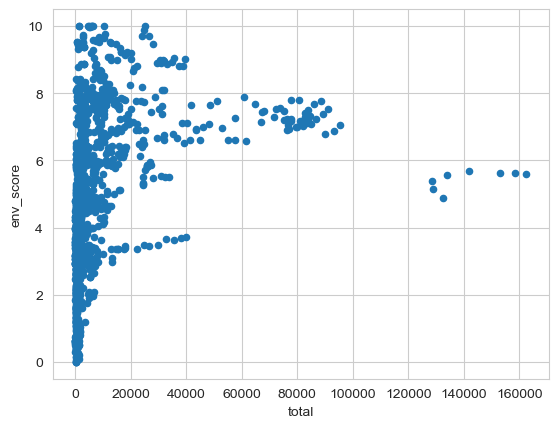

In [54]:
#Visualizing the relationship between weight and mpg in a scatterplot
df_analysis.plot('total', 'env_score', kind='scatter');

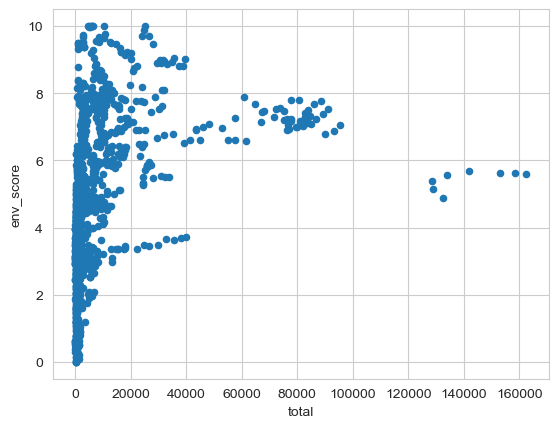

In [53]:
df_analysis_bc.plot('total', 'env_score', kind='scatter');

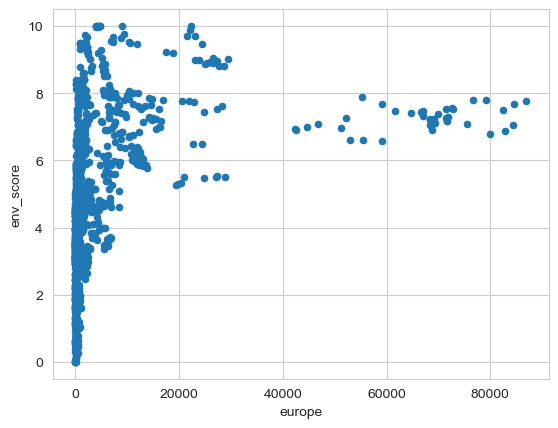

In [52]:
df_analysis_bc.plot('europe', 'env_score', kind='scatter');

### Correlation Matrix and Heatmap

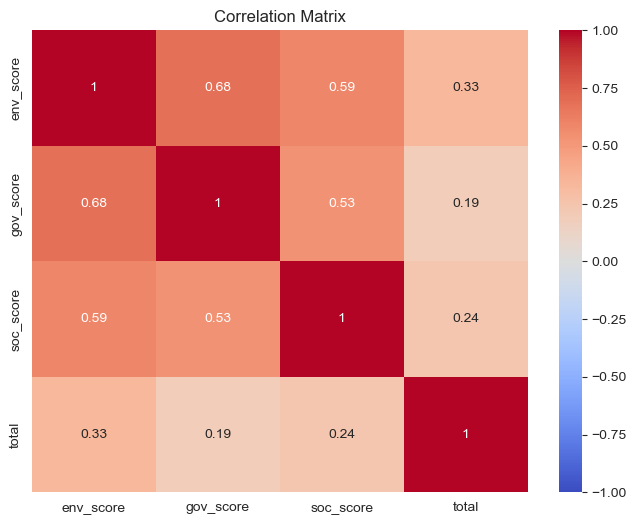

In [33]:
# Compute the correlation matrix
corr_matrix = df_analysis[['env_score', 'gov_score', 'soc_score', 'total']].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

The correlation coefficient of 0.38 suggests a moderate indicates a positive relationship between tourist numbers and environmental score. It is not extremely strong but still indicates a discernible association.

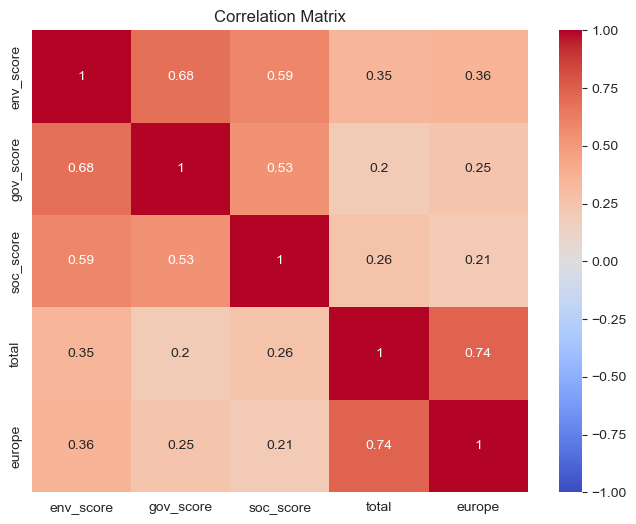

In [51]:
# Compute the correlation matrix
corr_matrix = df_analysis_bc[['env_score', 'gov_score', 'soc_score', 'total', 'europe']].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

### Simple linear regression

In [14]:
# Import the statsmodels module
import statsmodels.api as sm

In [15]:
# Prepare data for modeling
# Choose the predictor X and add a constant term
X = df_analysis[['env_score']]
# Our model needs an intercept so we add a column of 1s:
X = sm.add_constant(X)
# Define dependent variable
y = df_analysis['total']

In [16]:
# Create an OLS model
model = sm.OLS(y, X)
# use the data to calculate the intercept and slope
results = model.fit()
# return the output of the model
results.summary()

#Note: this can be written as sm.OLS(y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  total   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     185.6
Date:                Thu, 29 Jun 2023   Prob (F-statistic):           6.46e-40
Time:                        14:34:26   Log-Likelihood:                -16561.
No. Observations:                1487   AIC:                         3.313e+04
Df Residuals:                    1485   BIC:                         3.314e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4660.5041   1002.416     -4.649      0.000   -6626.805   -2694.203
env_score   2571.0386    188.709     13.624      0.000    2200.874    2941.203
==============================================================================
Omnibus:                     1427.535   Durbin-Watson:                   0.262
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            52926.753
Skew:                           4.623   Prob(JB):                         0.00
Kurtosis:                      30.726   Cond. No.                         12.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Dependent Variable: The dependent variable is "env_score," which is the variable being predicted or explained by the model.

R-squared: The R-squared value of 0.144 represents the proportion of the variance in the dependent variable that can be explained by the independent variable(s) included in the model. In this case, approximately 14.4% of the variation in the "env_score" can be accounted for by the independent variable(s) included in the regression model.

Model Fit: The adjusted R-squared value of 0.144 is the same as the R-squared value, indicating that no adjustments were made for the number of independent variables in the model.

F-statistic: The F-statistic tests the overall significance of the regression model. In this case, the F-statistic has a value of 250.0, and the associated probability (Prob (F-statistic)) is very close to zero (3.59e-52), indicating that the regression model as a whole is statistically significant.

Coefficients: The coefficients table provides information about the individual variables in the model. The "const" coefficient (4.0784) represents the intercept or the estimated value of the dependent variable when all independent variables are zero. The "total" coefficient (2.57e-05) represents the estimated change in the dependent variable for each unit increase in the "total" independent variable.

Standard Errors: The standard errors measure the uncertainty or precision of the coefficient estimates. The "std err" values indicate the standard errors associated with the corresponding coefficients.

t-values: The t-values assess the statistical significance of the coefficients. They are calculated by dividing the coefficient estimate by its standard error. The higher the absolute value of the t-value, the more statistically significant the coefficient. In this case, both the intercept ("const") and "total" coefficients have t-values indicating statistical significance (t > 2) as their associated p-values are very close to zero (p < 0.05).

Confidence Intervals: The confidence intervals provide a range within which we can be reasonably confident that the true population parameter lies. The values in the square brackets [0.025, 0.975] represent the lower and upper bounds of the 95% confidence intervals for the corresponding coefficients.

In [17]:
# Prepare data for modeling
# Choose the predictor X and add a constant term
Xbc = df_analysis_bc[['env_score']]
# Our model needs an intercept so we add a column of 1s:
Xbc = sm.add_constant(Xbc)
# Define dependent variable
y = df_analysis_bc['total']

In [18]:
# Create an OLS model
model = sm.OLS(y, Xbc)
# use the data to calculate the intercept and slope
results = model.fit()
# return the output of the model
results.summary()

#Note: this can be written as sm.OLS(y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  total   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     167.4
Date:                Thu, 29 Jun 2023   Prob (F-statistic):           6.00e-36
Time:                        14:34:26   Log-Likelihood:                -13574.
No. Observations:                1211   AIC:                         2.715e+04
Df Residuals:                    1209   BIC:                         2.716e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5103.1699   1183.949     -4.310      0.000   -7425.994   -2780.346
env_score   2892.5121    223.587     12.937      0.000    2453.850    3331.174
==============================================================================
Omnibus:                     1103.935   Durbin-Watson:                   0.289
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32181.302
Skew:                           4.306   Prob(JB):                         0.00
Kurtosis:                      26.740   Cond. No.                         12.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Multiple Regression

In [36]:
# Prepare data for modeling
# This time, we define two independent variables as X. We name it X2 though, since X is already used above.  
XM = df_analysis[['env_score', 'soc_score', 'gov_score']]
XM = sm.add_constant(XM)
# Our dependent variable stays the same
y = df_analysis['total']

In [37]:
# fit model and get model summery in one step
sm.OLS(y, XM).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  total   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     66.49
Date:                Thu, 29 Jun 2023   Prob (F-statistic):           2.43e-40
Time:                        15:46:25   Log-Likelihood:                -16555.
No. Observations:                1487   AIC:                         3.312e+04
Df Residuals:                    1483   BIC:                         3.314e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5690.5086   1520.270     -3.743      0.000   -8672.617   -2708.401
env_score   2708.3155    277.187      9.771      0.000    2164.596    3252.035
soc_score    739.7103    277.077      2.670      0.008     196.206    1283.214
gov_score   -784.0828    274.863     -2.853      0.004   -1323.245    -244.921
==============================================================================
Omnibus:                     1411.782   Durbin-Watson:                   0.263
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            49787.701
Skew:                           4.562   Prob(JB):                         0.00
Kurtosis:                      29.839   Cond. No.                         36.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Dependent Variable: The dependent variable is "total," which is the variable being predicted or explained by the model.

R-squared: The R-squared value of 0.151 represents the proportion of the variance in the dependent variable that can be explained by the independent variables included in the model. Approximately 15.1% of the variation in the "total" variable can be accounted for by the independent variables.

Model Fit: The adjusted R-squared value of 0.149 suggests that the model's goodness of fit is slightly reduced when considering the number of independent variables included.

F-statistic: The F-statistic tests the overall significance of the regression model. In this case, the F-statistic has a value of 87.78, and the associated probability (Prob (F-statistic)) is very close to zero (2.76e-52), indicating that the regression model as a whole is statistically significant.

Coefficients: The coefficients table provides information about the individual variables in the model. The "const" coefficient represents the intercept or the estimated value of the dependent variable when all independent variables are zero. The coefficients for "env_score," "soc_score," and "gov_score" represent the estimated change in the dependent variable for a one-unit increase in each respective independent variable.

Standard Errors: The standard errors measure the uncertainty or precision of the coefficient estimates. The "std err" values indicate the standard errors associated with the corresponding coefficients.

t-values: The t-values assess the statistical significance of the coefficients. They are calculated by dividing the coefficient estimate by its standard error. In this case, all three independent variables ("env_score," "soc_score," and "gov_score") have t-values indicating statistical significance (t > 2) as their associated p-values are very close to zero (p < 0.05).

Confidence Intervals: The confidence intervals provide a range within which we can be reasonably confident that the true population parameter lies. The values in the square brackets [0.025, 0.975] represent the lower and upper bounds of the 95% confidence intervals for the corresponding coefficients.

Additional Statistics: The Omnibus, Durbin-Watson, Jarque-Bera, Skewness, and Kurtosis values provide additional information about the model's goodness-of-fit and assumptions. These statistics assess aspects such as normality, autocorrelation, and model stability.

Number of Observations and Degrees of Freedom: The number of observations (1487) indicates the total number of data points used in the regression analysis. The degrees of freedom for the residuals (1483) and the model (3) represent the number of independent pieces of information available for estimating the residuals and the model parameters, respectively.

Covariance Type: The covariance type is specified as "nonrobust," which indicates that standard ordinary least squares (OLS) estimation methods were used, assuming homoscedasticity and no influential outliers.

In [21]:
# Prepare data for modeling
# This time, we define two independent variables as X. We name it X2 though, since X is already used above.  
XMbc = df_analysis_bc[['env_score', 'soc_score', 'gov_score']]
XMbc = sm.add_constant(XMbc)
# Our dependent variable stays the same
y = df_analysis_bc['total']

In [22]:
# fit model and get model summery in one step
sm.OLS(y, XMbc).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  total   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     60.51
Date:                Thu, 29 Jun 2023   Prob (F-statistic):           1.91e-36
Time:                        14:34:26   Log-Likelihood:                -13568.
No. Observations:                1211   AIC:                         2.714e+04
Df Residuals:                    1207   BIC:                         2.716e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7035.5673   1775.202     -3.963      0.000   -1.05e+04   -3552.743
env_score   2923.2295    326.911      8.942      0.000    2281.852    3564.607
soc_score    988.1300    326.761      3.024      0.003     347.047    1629.213
gov_score   -813.4659    324.108     -2.510      0.012   -1449.344    -177.588
==============================================================================
Omnibus:                     1089.037   Durbin-Watson:                   0.291
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29969.743
Skew:                           4.239   Prob(JB):                         0.00
Kurtosis:                      25.849   Cond. No.                         35.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/var/folders/lq/66qmb5qs6yx8s8h1s8rmqnh80000gn/T/ipykernel_13878/4078824328.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analysis_bc['kmeans_cluster'] = kmeans_labels


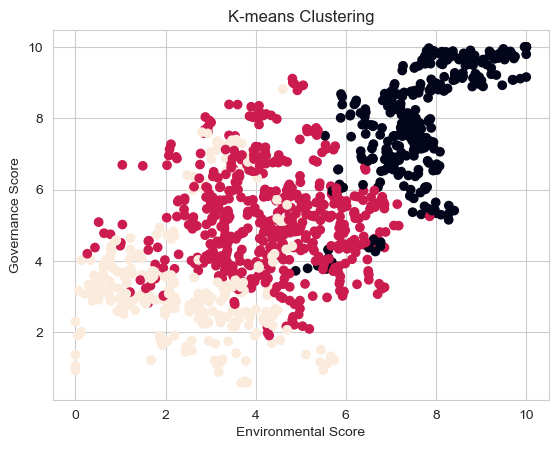

In [40]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Select the relevant variables for clustering
data = df_analysis_bc[['env_score', 'gov_score', 'soc_score', 'total']]

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Perform K-means clustering
kmeans = KMeans(n_clusters=3)  # Specify the number of clusters
kmeans.fit(scaled_data)
kmeans_labels = kmeans.labels_


# Add the cluster labels to the original DataFrame
df_analysis_bc['kmeans_cluster'] = kmeans_labels

# Visualize the clusters
plt.scatter(df_analysis_bc['env_score'], df_analysis_bc['gov_score'], c=df_analysis_bc['kmeans_cluster'])
plt.xlabel('Environmental Score')
plt.ylabel('Governance Score')
plt.title('K-means Clustering')
plt.show()
